In [1]:
%pylab inline

import matplotlib as pyplot
import os
import pandas as pd

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
SCORETYPE = ""
MINDIST = 1500
MINQ = 1
percentiles = [0, 50] + list(np.arange(60, 101, 10))


# Annotate TSS/UTRs
def GetDistTss(x):
    if x["strand"] == "+":
        return x["best.str.start"] - x["start"]
    elif x["strand"] == "-":
        return -1*(x["best.str.start"] - x["stop"])
    else:
        return float("nan")


def GetBootstrapCI(data, func):
    numiter = 1000
    vals = []
    for i in range(numiter):
        x = np.random.choice(data, size=data.shape[0], replace=True)
        vals.append(func(x))
    se = np.sqrt(np.var(vals))
    return np.mean(vals)-1.96*se, np.mean(vals)+1.96*se


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot TSS/TES
data1 = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes%s.tab"%SCORETYPE), sep="\t")
data1 = data1[data1["best.score"] >= 0]
GG = pd.read_csv('/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv', sep='\t')
EE =GG.loc[GG['E.tissues']>=1]

data = data1.loc[data1['gene'].isin(list(EE['gene']))]

bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)
binlabels = []
tss = []
tss_low = []
tss_high = []
tes = []
tes_low = []
tes_high = []
KST = []
for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1] 
    x = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
    KST.append([lb,ub,x])
    print(lb,'\t',ub, x.shape)
    feature_tss = x["dist.to.tss"].apply(lambda x: abs(x)<MINDIST)
    feature_tes = x["dist.to.tes"].apply(lambda x: abs(x)<MINDIST)
    count_tss = np.mean(feature_tss)
    count_tes = np.mean(feature_tes)
    low_tss, high_tss = GetBootstrapCI(feature_tss, np.mean)
    low_tes, high_tes = GetBootstrapCI(feature_tes, np.mean)
    if i == 0:
        base_tss = count_tss
        base_tes = count_tes
    binlabels.append("%s-%s"%(percentiles[i], percentiles[i+1]))
    tss.append(count_tss*1.0/base_tss)
    tss_low.append(low_tss*1.0/base_tss)
    tss_high.append(high_tss*1.0/base_tss)
    tes.append(count_tes*1.0/base_tes)
    tes_low.append(low_tes*1.0/base_tes)
    tes_high.append(high_tes*1.0/base_tes)

6.48097e-43 	 0.0254803 (3232, 8)
0.0254803 	 0.03593124 (646, 8)
0.03593124 	 0.05158585999999992 (646, 8)
0.05158585999999992 	 0.07851912000000007 (647, 8)
0.07851912000000007 	 0.1456148 (646, 8)
0.1456148 	 0.9999979999999999 (647, 8)


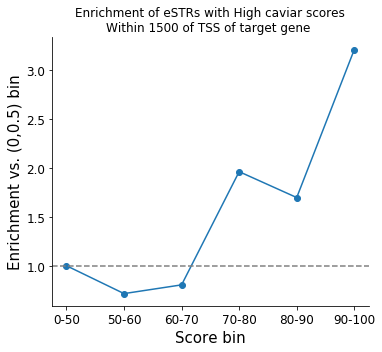

In [3]:
fig = plt.figure()
fig.set_size_inches((10, 5))

# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o")
ax.set_xlabel("Score bin", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Enrichment of eSTRs with High caviar scores\nWithin %s of TSS of target gene "%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()


In [17]:
K = KST[-1][-1]       #pd.concat([KST[4][-1], KST[5][-1], KST[3][-1]])#top 3 bins   
GG['best.str.start'] = GG['str.start']
G = GG[["chrom","best.str.start","gene","motif","E.tissues"]]
DD = pd.merge(K, G, on=["chrom","best.str.start","gene"])
#There are 244 in the top bin
#there are 16 of these causal genes that are eSTRs in more that 9 tissues
DD.loc[DD['E.tissues']>=9]#[['gene','best.str.start']]


,gene,chrom,best.str.start,best.score,best.tissue,best.q,dist.to.tss,dist.to.tes,motif,E.tissues
30,ENSG00000203880.7,chr20,6.2893e+07,0.139151,Thyroid,0.001820,5857.0,-33904.0,A,10.0
31,ENSG00000163444.7,chr1,2.02979e+08,0.082561,Skin-NotSunExposed,0.005283,2753.0,-14709.0,A,11.0
70,ENSG00000113119.8,chr5,1.40113e+08,0.084153,Esophagus-Muscularis,0.049138,93826.0,87969.0,AC,9.0
72,ENSG00000130517.9,chr19,1.84437e+07,0.099021,Artery-Aorta,0.003371,-7697.0,-37060.0,AAC,11.0
82,ENSG00000168653.6,chr1,3.94847e+07,0.109265,Brain-Caudate,0.070162,-7279.0,-15597.0,AAAT,13.0
101,ENSG00000118197.9,chr1,2.00641e+08,0.142153,Heart-LeftVentricle,0.005170,-1706.0,-47779.0,AT,11.0
166,ENSG00000187049.5,chr11,6.11587e+07,0.097060,Skin-SunExposed,0.002019,-434.0,-7610.0,C,10.0
176,ENSG00000087191.8,chr17,6.1935e+07,0.079375,Muscle-Skeletal,0.008363,29930.0,25583.0,A,13.0
193,ENSG00000131351.10,chr19,1.71682e+07,0.088709,Artery-Tibial,0.002366,18274.0,-7622.0,A,9.0
213,ENSG00000198466.8,chr19,5.83183e+07,0.125396,Brain-Cerebellum,0.007569,-46863.0,-58199.0,A,14.0


In [19]:
# TES
ax = fig.add_subplot(122)
#ax.errorbar(range(len(binlabels)), tes, marker="o", yerr = [tes_low, tes_high])
ax.plot(range(len(binlabels)), tes, marker="o")
ax.set_xlabel("Score bin", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Within %s of TES"%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#data["abs.dist.tss"] = abs(data["dist.to.tss"])
#data.sort_values("best.score", ascending=False)
plt.show()